<h4> Project for the subject „Scientific computing and data visualization in Python” <br>
<br> 
Author: Daryna Yakymenko <br> 
Date: 16-06-2025 <br> 

# Automated Classification of Nuclear Replication Patterns

In [1]:
import numpy as np
import pandas as pd
from tifffile import imread

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, jaccard_score

from skimage.io import imread
from skimage import measure
from skimage.measure import label, regionprops, regionprops_table, find_contours
from skimage.segmentation import find_boundaries
from skimage.color import label2rgb, gray2rgb
from skimage.filters.rank import entropy
from skimage.morphology import disk
from scipy.ndimage import distance_transform_edt

In [5]:
image = imread(r".\Sample1_control_x20_dry.lif - field_5.tif")  #[y, x, c]

#image shape
print("Image shape:", image.shape) 

Image shape: (1024, 1024, 3)


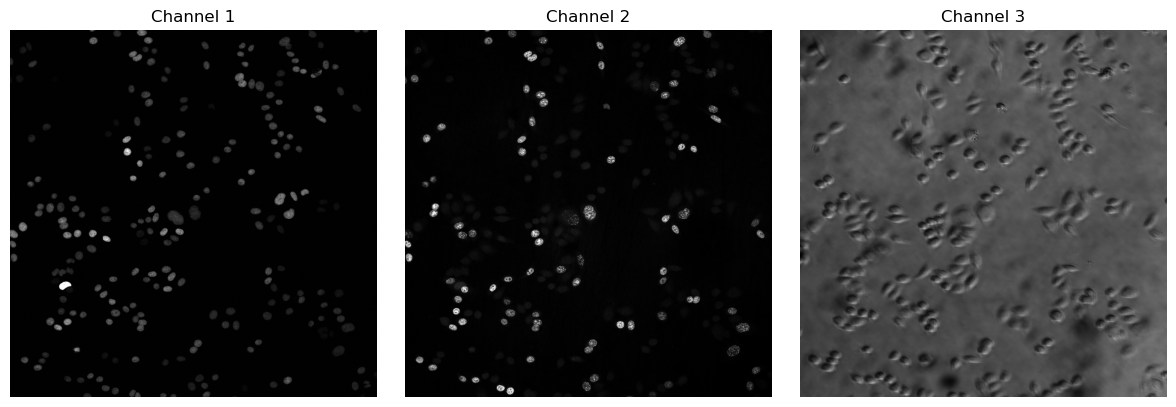

In [7]:
#show channels
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    axes[i].imshow(image[...,i], cmap='gray')
    axes[i].set_title(f'Channel {i+1}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

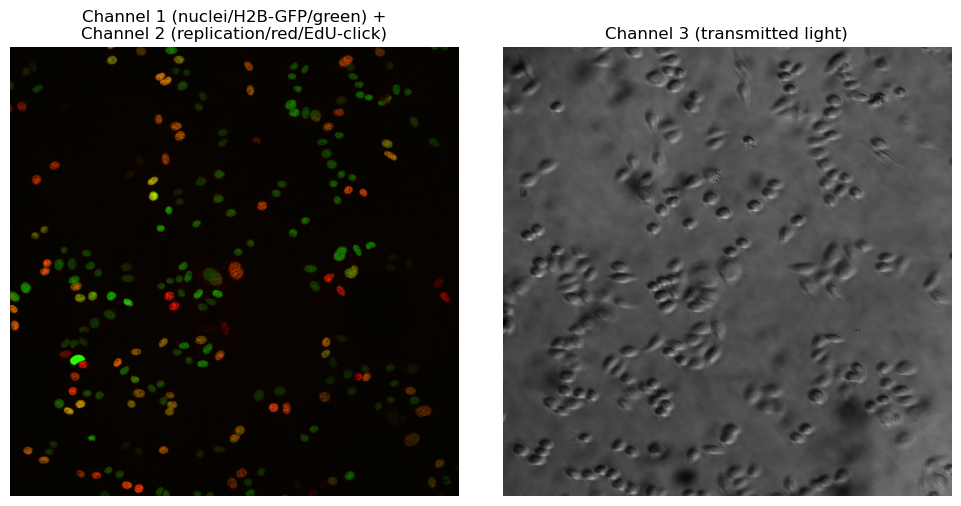

In [9]:
#normalize to [0,1]
image = image.astype(np.float32)
image = image / image.max()

ch1 = image[:,:,0]  #green
ch2 = image[:,:,1]  #red
ch3 = image[:,:,2]  #black-white

#RGB from channles 1&2 only 
rgb = np.stack([ch2, ch1, np.zeros_like(ch1)], axis=-1)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(rgb)
axes[0].set_title("Channel 1 (nuclei/H2B-GFP/green) +\nChannel 2 (replication/red/EdU-click)")
axes[0].axis('off')

axes[1].imshow(ch3, cmap='gray')
axes[1].set_title("Channel 3 (transmitted light)")
axes[1].axis('off')

plt.tight_layout()
plt.show()

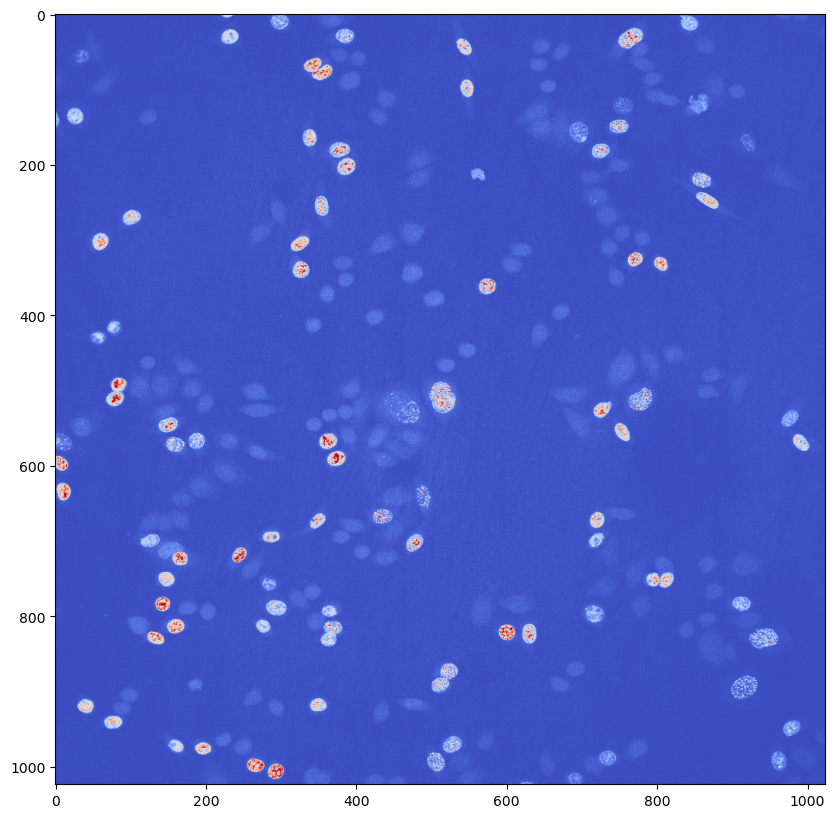

In [11]:
plt.figure(figsize=(28, 10))
plt.imshow(image[:,:,1], cmap = 'coolwarm')

In [13]:
#labels
labels = imread(r".\Sample1_control_x20_dry.lif - field_5_objects.tif")
print("Image shape:", image.shape)

Image shape: (1024, 1024, 3)


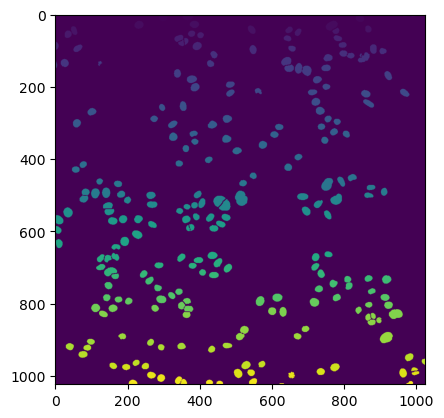

In [15]:
#labels as separate objects
plt.imshow(labels)

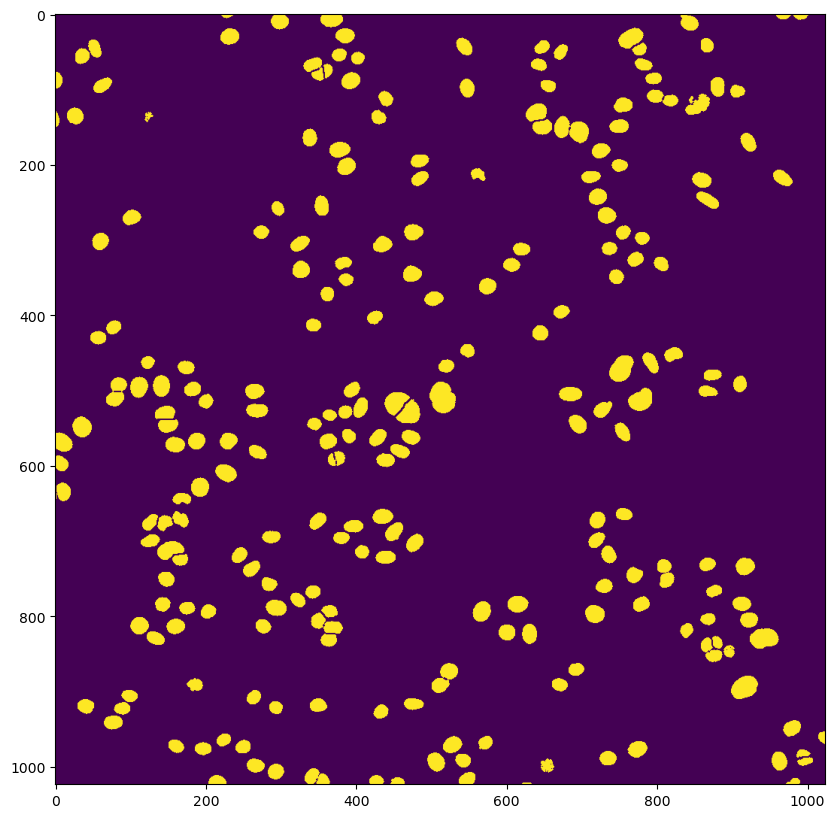

In [17]:
#mask for all the labels
plt.figure(figsize=(28, 10))
mask = labels > 0
plt.imshow(mask)

Class 1 - bad mask <br>
Class 2 - replication (S) <br>
Class 3 - prophase (G1/G2) <br>
Class 4 - mitosis (M) <br>

In [21]:
#classes - created manually
df = pd.read_csv(r".\\Classes.csv", sep = ";")
print(df)

     Labele  Class
0         1      0
1         2      1
2         3      2
3         4      0
4         5      0
..      ...    ...
226     227      0
227     228      0
228     229      0
229     230      0
230     231      0

[231 rows x 2 columns]


In [23]:
df["Class"] = df["Class"] + 1
print(df.head())

   Labele  Class
0       1      1
1       2      2
2       3      3
3       4      1
4       5      1


In [25]:
label_to_class = dict(zip(df["Labele"], df["Class"]))

In [27]:
# labels is a label map (created with napari)
class_map = np.zeros_like(labels, dtype=np.uint8) 
for label_id, class_id in label_to_class.items():
    class_map[labels == label_id] = class_id

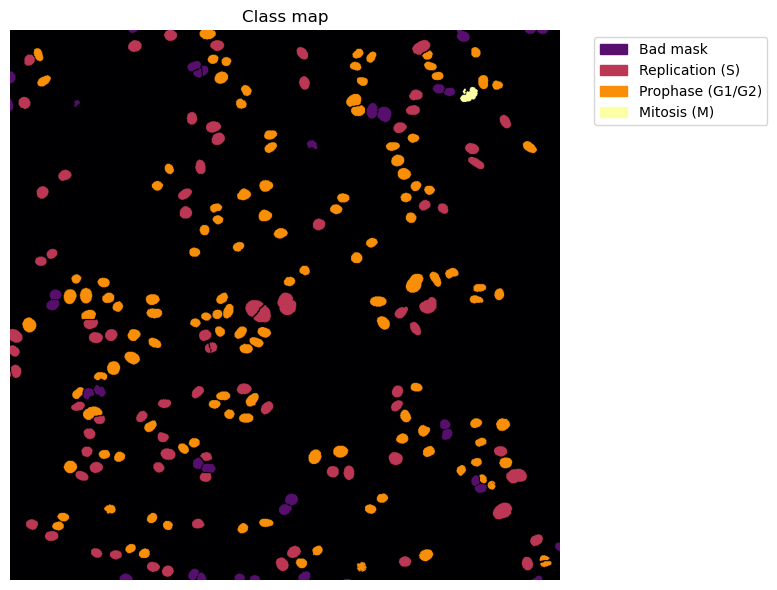

In [29]:
class_ids = [1, 2, 3, 4]
class_names = ["Bad mask", "Replication (S)", "Prophase (G1/G2)", "Mitosis (M)"]

cmap = plt.get_cmap('inferno', max(class_ids) + 1)

plt.figure(figsize=(10, 6))
plt.imshow(class_map, cmap=cmap, vmin=0, vmax=max(class_ids))  # Ustaw zakres jawnie
plt.title("Class map")
plt.axis('off')

patches = [mpatches.Patch(color=cmap(cls_id), label=name)
           for cls_id, name in zip(class_ids, class_names)]

plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

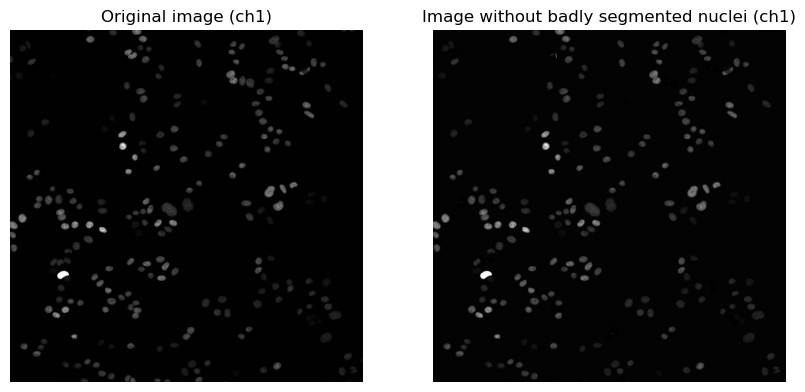

In [31]:
good_masks_ch1 = image[:, :, 0].copy()

#delete objects from class 1 (bad mask)
good_masks_ch1[class_map == 1] = 0  

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(image[:, :, 0],  cmap='gray')
axes[0].set_title("Original image (ch1)")
axes[0].axis('off')

axes[1].imshow(good_masks_ch1,  cmap='gray')
axes[1].set_title("Image without badly segmented nuclei (ch1)")
axes[1].axis('off')

plt.show()

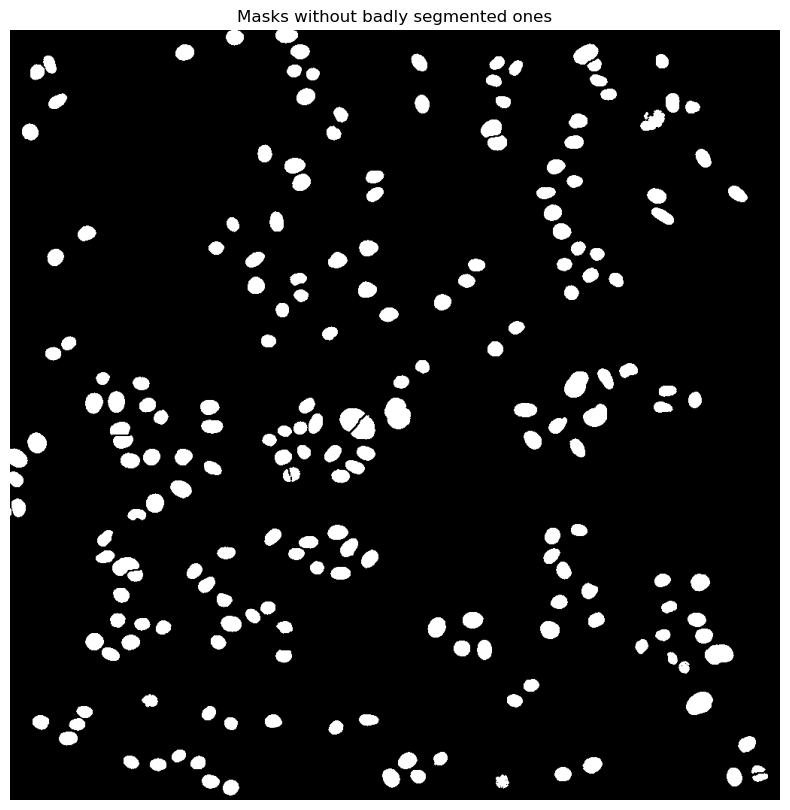

In [33]:
good_masks = (class_map > 0) & (class_map != 1)
plt.figure(figsize=(10, 10))
plt.imshow(good_masks, cmap='gray')
plt.title("Masks without badly segmented ones")
plt.axis('off')
plt.show()

In [35]:
print(good_masks)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [37]:
good_masks_ch1 =good_masks_ch1.astype(np.float32)
good_masks = good_masks.astype(np.uint8)

#Normalization to 0–1
#good_masks_ch1 /= 255.0

H, W = good_masks.shape

#if the image is 2D - add channels dimension 
if good_masks_ch1.ndim == 2:
    good_masks_ch1 = good_masks_ch1[..., np.newaxis]

#data conversion into a list of pixels (N x C)
X = good_masks_ch1.reshape(-1, good_masks_ch1.shape[2]) #features
y = good_masks.flatten() #labels

In [39]:
good_masks.shape, good_masks_ch1.shape

((1024, 1024), (1024, 1024, 1))

## 1 - Pixel classification: objects/background

### Model training 

In [41]:
img1 = imread(r".\Sample1_control_x20_dry.lif - field_1.tif")
img1_ch1 = img1[:, :, 0].copy()
img2 = imread(r".\Sample1_control_x20_dry.lif - field_2.tif")
img2_ch1 = img2[:, :, 0].copy()
img3 = imread(r".\Sample1_control_x20_dry.lif - field_3.tif")
img3_ch1 = img3[:, :, 0].copy()
img4 = imread(r".\Sample1_control_x20_dry.lif - field_4.tif")
img4_ch1 = img4[:, :, 0].copy()
#img5 = imread(r"C:\Users\evgen\OneDrive\Desktop\Desferal\24-03-25\Sample1_control_x20_dry\Sample1_control_x20_dry.lif - field_5.tif")
#img5_ch1 = img5[:, :, 0].copy()

img6 = imread(r".\Sample2_control_x20_dry.lif - field_1.tif")
img6_ch1 = img6[:, :, 0].copy()
img7 = imread(r".\Sample2_control_x20_dry.lif - field_2.tif")
img7_ch1 = img7[:, :, 0].copy()
img8 = imread(r".\Sample2_control_x20_dry.lif - field_3.tif")
img8_ch1 = img8[:, :, 0].copy()
img9 = imread(r".\Sample2_control_x20_dry.lif - field_4.tif")
img9_ch1 = img9[:, :, 0].copy()
img10 = imread(r".\Sample2_control_x20_dry.lif - field_5.tif")
img10_ch1 = img10[:, :, 0].copy()

In [47]:
mask1=imread(r".\Sample1_control_x20_dry.lif - field_1_mask.tif")
mask2=imread(r".\Sample1_control_x20_dry.lif - field_2_mask.tif")
mask3=imread(r".\Sample1_control_x20_dry.lif - field_3_mask.tif")
mask4=imread(r".\Sample1_control_x20_dry.lif - field_4_mask.tif")
#mask5=mask

mask6=imread(r".\Sample2_control_x20_dry.lif - field_1_mask.tif")
mask7=imread(r".\Sample2_control_x20_dry.lif - field_2_mask.tif")
mask8=imread(r".\Sample2_control_x20_dry.lif - field_3_mask.tif")
mask9=imread(r".\Sample2_control_x20_dry.lif - field_4_mask.tif")
mask10=imread(r".\Sample2_control_x20_dry.lif - field_5_mask.tif")

In [49]:
images = [img1_ch1, img2_ch1, img3_ch1, img4_ch1, img6_ch1, img7_ch1,  img8_ch1, img9_ch1, img10_ch1]
masks = [mask1, mask2, mask3, mask4, mask6, mask7, mask8, mask9, mask10]
masks = [np.where(mask == 255, 1, mask) for mask in masks]

In [51]:
#Normalization throught diviusion by 255
images = [img.astype(np.float32) / 255.0 for img in images]

In [53]:
def prepare_data(image, mask):
    if image.ndim == 2:
        image = image[..., np.newaxis]
    X = image.reshape(-1, image.shape[2]) #pixels are features
    y = mask.flatten() #pixels are labels
    return X, y

In [55]:
#all images in a one set
X_all = []
y_all = []

for img, msk in zip(images, masks):
    X_tmp, y_tmp = prepare_data(img, msk)
    X_all.append(X_tmp)
    y_all.append(y_tmp)

X_all = np.vstack(X_all)
y_all = np.hstack(y_all)

In [57]:
#Train/test sets:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=1)

In [59]:
from collections import Counter
print(Counter(y_all))

Counter({0: 8313259, 1: 1123925})


In [61]:
#feature scaling
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [63]:
%%time
#Random Forest model training 
forest = RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=1)
forest.fit(X_train_std, y_train)
#Accuracy
#print("Accuracy:", forest.score(X_test_std, y_test))

CPU times: total: 26.7 s
Wall time: 27.2 s


RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=1)

Accuracy: 0.9941
Confusion Matrix:
 [[1660645    2251]
 [   8882  215659]]


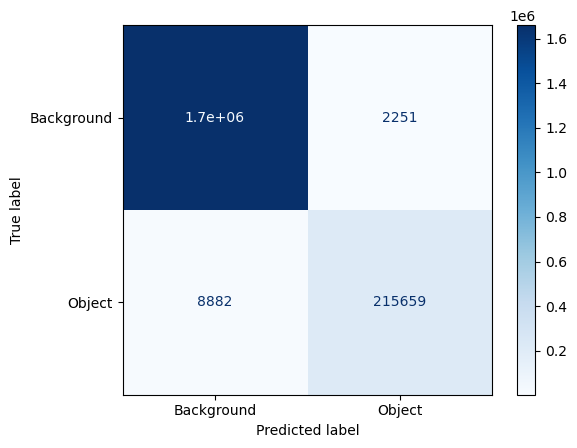

In [65]:
y_pred = forest.predict(X_test_std)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Background", "Object"])
disp.plot(cmap="Blues")

### Model benchmarking 

In [69]:
image_5 = imread(r".\Sample1_control_x20_dry.lif - field_5.tif")
new_img  = image_5[:, :, 0].copy()

def prepare_image_for_prediction(image):
    if image.ndim == 2:
        image = image[..., np.newaxis]
    image = image.astype(np.float32) / 255.0 
    H, W = image.shape[:2]
    X = image.reshape(-1, image.shape[2])
    return X, H, W

X_new, H, W = prepare_image_for_prediction(new_img)

X_new_std = sc.transform(X_new)
y_pred = forest.predict(X_new_std)
mask_pred = y_pred.reshape(H, W)

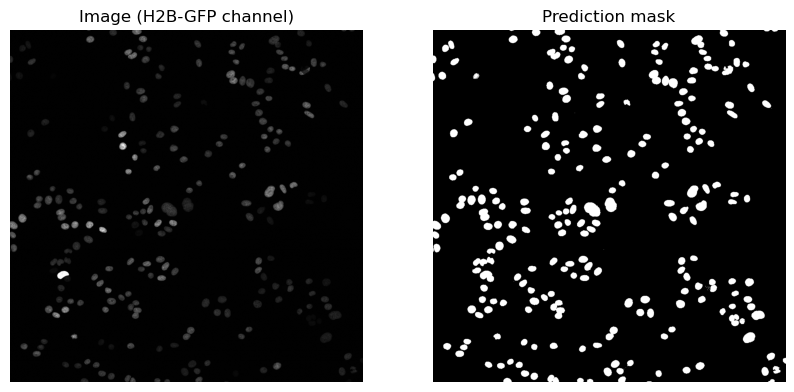

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].set_title("Image (H2B-GFP channel)")
axes[0].axis("off")
axes[0].imshow(new_img, cmap='gray')

axes[1].set_title("Prediction mask")
axes[1].axis("off")
axes[1].imshow(mask_pred, cmap='gray')

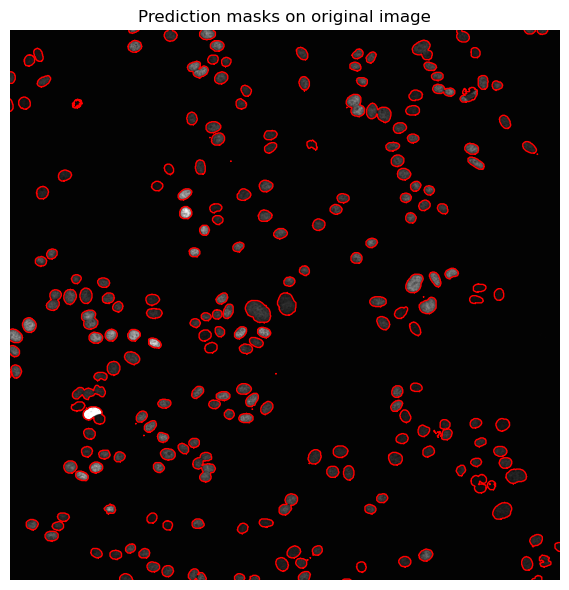

In [73]:
#Counturs of objects on the mask 
contours = measure.find_contours(mask_pred, level=0.8)
#to RGB
overlay_img = gray2rgb(new_img.astype(np.float32) / 255.0)

fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(overlay_img)
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color='red')
ax.set_title("Prediction masks on original image")
ax.axis('off')
plt.tight_layout()
plt.show()

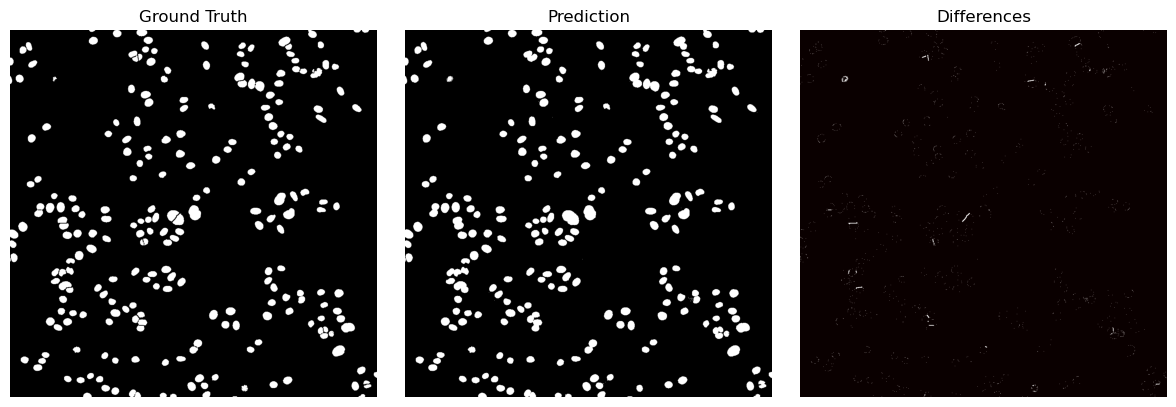

In [74]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(mask, cmap='gray')
plt.title('Ground Truth')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask_pred, cmap='gray')
plt.title('Prediction')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(mask != mask_pred, cmap='hot') 
plt.title('Differences')
plt.axis('off')

plt.tight_layout()
plt.show()

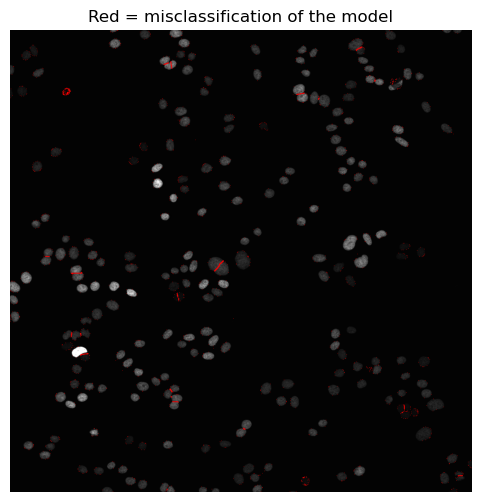

In [75]:
overlay_img = gray2rgb(new_img.astype(np.float32) / 255.0)

#Difference between images
diff_mask = (mask != mask_pred)

overlay_img[diff_mask, 0] = 1.0  # R
overlay_img[diff_mask, 1] = 0.0  # G
overlay_img[diff_mask, 2] = 0.0  # B

plt.figure(figsize=(8, 6))
plt.imshow(overlay_img)
plt.title("Red = misclassification of the model")
plt.axis('off')
plt.show()

In [77]:
acc2 = accuracy_score(mask.flatten(), mask_pred.flatten())
print(f"Accuracy: {acc2:.4f}")

print(confusion_matrix(mask.flatten(), mask_pred.flatten()))
print(classification_report(mask.flatten(), mask_pred.flatten(), target_names=["Background", "Objects"]))

jc = jaccard_score(mask.flatten(), mask_pred.flatten())
print(f"Jaccard Index: {jc:.4f}")

Accuracy: 0.9978
[[963044   2358]
 [     0  83174]]
              precision    recall  f1-score   support

  Background       1.00      1.00      1.00    965402
     Objects       0.97      1.00      0.99     83174

    accuracy                           1.00   1048576
   macro avg       0.99      1.00      0.99   1048576
weighted avg       1.00      1.00      1.00   1048576

Jaccard Index: 0.9724


## 2 - Object classification: G1/G2 vs S

In [79]:
#image5 
nuclei = image_5[:, :, 0].copy()
replication = image_5[:, :, 1].copy()
brightfield = image_5[:, :, 2].copy()

In [81]:
mask = labels > 0  # binary mask

In [83]:
#Separation of objects (nuclei) => labeling of individual objects
labeled_mask = label(mask, connectivity=1)

In [85]:
#Objects filtering based on size (area) parameter
props = regionprops_table(labeled_mask, properties=["label", "area"])
df_props = pd.DataFrame(props)

#only 100-1000 pixels 
valid_labels = df_props[(df_props["area"] > 100) & (df_props["area"] < 1000)]["label"]
filtered_mask = np.isin(labeled_mask, valid_labels)
filtered_labeled = label(filtered_mask)

filtered_labeled_mask = filtered_labeled > 0 
diff = (mask != filtered_labeled_mask).astype(np.uint8)

(-0.5, 1023.5, 1023.5, -0.5)

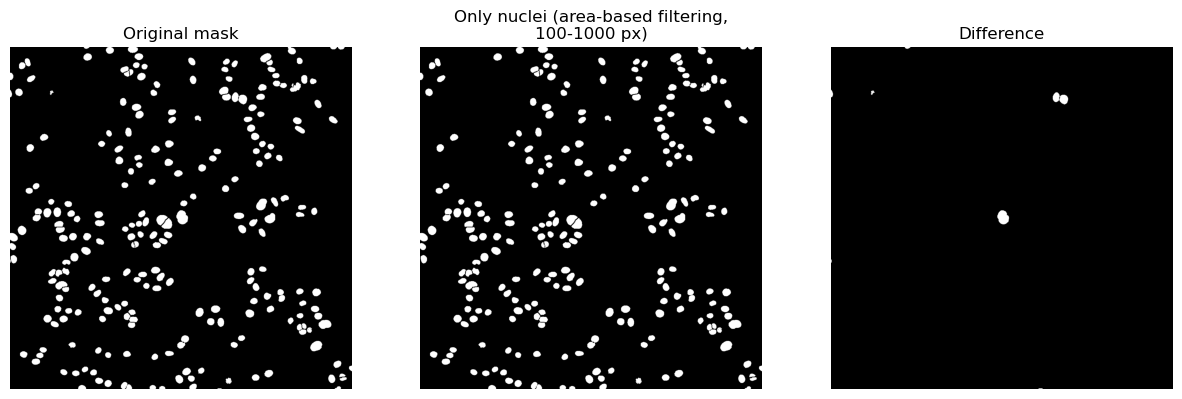

In [89]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(mask, cmap='gray')
axes[0].set_title("Original mask")
axes[0].axis('off')

axes[1].imshow(filtered_labeled>0, cmap='gray')
axes[1].set_title("Only nuclei (area-based filtering,\n100-1000 px)")
axes[1].axis('off')

axes[2].imshow(diff, cmap='gray')
axes[2].set_title("Difference")
axes[2].axis('off')


In [87]:
filtered_labeled.shape, replication.shape

((1024, 1024), (1024, 1024))

### Objects features selection & extraction

In [89]:
def  objects_features(filtered_labeled, replication):
    props = regionprops_table(
        filtered_labeled, 
        intensity_image=replication,
        properties=('label', 'area', 'mean_intensity', 'max_intensity', 'min_intensity','intensity_std')
    )
    
    df_features = pd.DataFrame(props)

    #Entropy
    shape = np.array(filtered_labeled.shape)
    center = shape / 2

    def entropy(intensities):
        if len(intensities) == 0:
            return 0
        hist, _ = np.histogram(intensities, bins=256, range=(intensities.min(), intensities.max()), density=True)
        hist = hist[hist > 0]
        return -np.sum(hist * np.log2(hist))

    entropy_list = []
    for label in df_features['label']:
        mask = filtered_labeled == label
        intensities = replication[mask]
        entropy_list.append(entropy(intensities))

    df_features['entropy'] = entropy_list

    #total_intensity = mean_intensity*area
    df_features["total_intensity"] = df_features["mean_intensity"] * df_features["area"]
    #background signal (calculated based on pixels that don't belong to any kernel
    background = np.median(replication[filtered_labeled == 0])
    #background_corrected_intensity
    df_features["background_corrected_intensity"] = df_features["total_intensity"] - (background * df_features["area"])

    return df_features

In [91]:
df_features = objects_features(filtered_labeled, replication)
print(df_features.head())

   label   area  mean_intensity  max_intensity  min_intensity  intensity_std  \
0      1  389.0       59.994859          178.0           10.0      26.164891   
1      2  440.0       17.690909           31.0            8.0       4.197933   
2      3  409.0       69.212714          133.0           12.0      24.586084   
3      4  113.0       14.008850           21.0            6.0       2.999987   
4      5  119.0       13.722689           21.0            9.0       2.386673   

     entropy  total_intensity  background_corrected_intensity  
0   8.761428          23338.0                         21004.0  
1   6.750522           7784.0                          5144.0  
2  11.310529          28308.0                         25854.0  
3 -10.194151           1583.0                           905.0  
4 -24.926218           1633.0                           919.0  


### Classification 

In [93]:
#X = df_features[["background_corrected_intensity", "area"]
X = df_features[["area", "mean_intensity", "intensity_std", "entropy", "intensity_std", "max_intensity", "min_intensity"]]
X_scaled = StandardScaler().fit_transform(X)

In [95]:
kmeans = KMeans(n_clusters=3, random_state=42)
df_features["cluster"] = kmeans.fit_predict(X_scaled)

C:\Users\evgen\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


### Visualization 

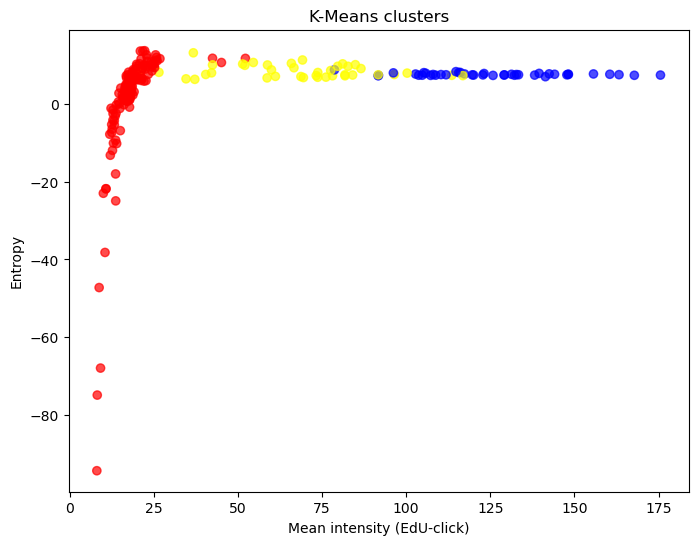

In [97]:
colors = ['red', 'blue', 'yellow']
cluster_colors = df_features['cluster'].map(lambda x: colors[x])
plt.figure(figsize=(8, 6))
plt.scatter(df_features["mean_intensity"], df_features["entropy"], c=cluster_colors, alpha=0.7)
plt.xlabel("Mean intensity (EdU-click)")
plt.ylabel("Entropy")
plt.title("K-Means clusters")
plt.show()

<Figure size 1000x1000 with 0 Axes>

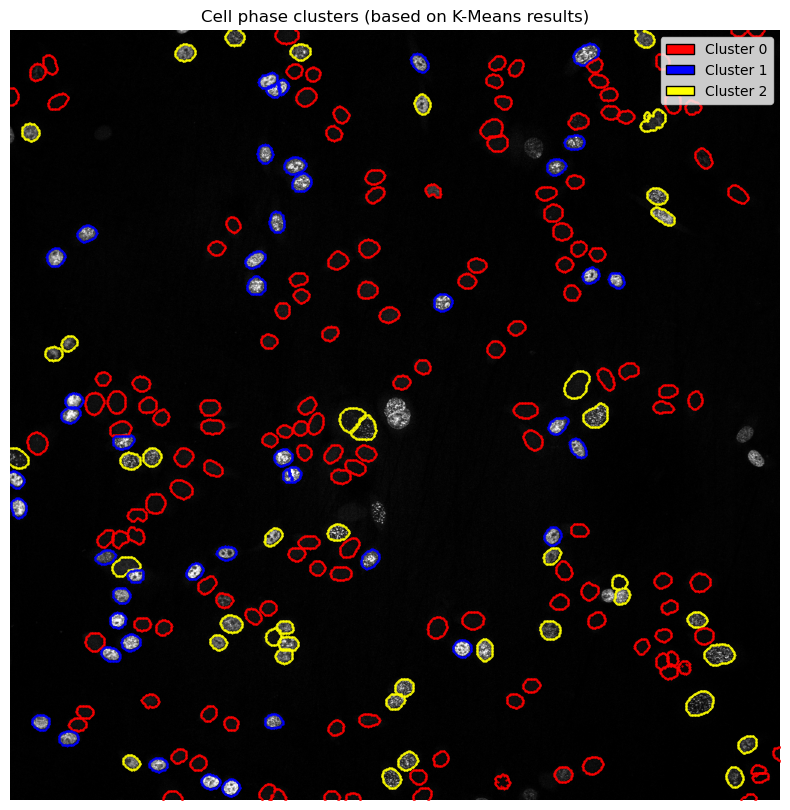

In [99]:
plt.figure(figsize=(10, 10))

colors = ['red', 'blue', 'yellow'] 

plt.figure(figsize=(10,10))
plt.imshow(replication, cmap='gray')

for label in df_features['label']:
    cluster = df_features.loc[df_features['label'] == label, 'cluster'].values[0]
    mask = (filtered_labeled == label)
    #masks boundaries
    boundaries = find_boundaries(mask, mode='outer')
    #boundaries coordinates
    ys, xs = np.where(boundaries)
    #add boundaries on  image
    plt.plot(xs, ys, '.', color=colors[cluster], markersize=1)

legend_elements = [Patch(facecolor=colors[i], edgecolor='k', label=f'Cluster {i}') for i in range(len(colors))]
plt.legend(handles=legend_elements, loc='upper right')
plt.title("Cell phase clusters (based on K-Means results)")
plt.axis('off')
plt.show()

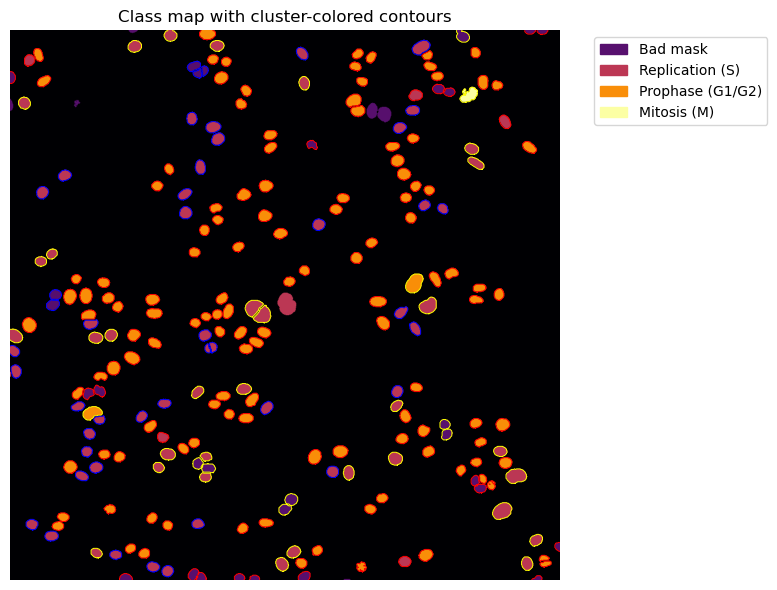

In [100]:
colors = ['red', 'blue', 'yellow', 'green']
class_ids = [1, 2, 3, 4]
class_names = ["Bad mask", "Replication (S)", "Prophase (G1/G2)", "Mitosis (M)"]
cmap = plt.get_cmap('inferno', max(class_ids) + 1)

plt.figure(figsize=(10, 6))
plt.imshow(class_map, cmap=cmap, vmin=0, vmax=max(class_ids)) 
for label in np.unique(filtered_labeled):
    if label == 0:
        continue  #omitting background
    mask = filtered_labeled == label
    contours = find_contours(mask.astype(float), level=0.5)
    cluster = df_features.loc[df_features['label'] == label, 'cluster'].values[0]
    contour_color = colors[cluster]
    for contour in contours:
        plt.plot(contour[:, 1], contour[:, 0], color=contour_color, linewidth=0.7)

patches = [mpatches.Patch(color=cmap(cls_id), label=name)
           for cls_id, name in zip(class_ids, class_names)]

plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Class map with cluster-colored contours")
plt.axis('off')
plt.tight_layout()
plt.show()